
# **Report: Matrix Multiplication Performance Comparison**

##Student Information
#####MSSV: 23120067
#####Name: Lê Minh Nhật


##**1. INTRODUCTION**


**Deliverables:** C implementation, timing framework, and comprehensive report.

This notebook compares runtime performance of matrix multiplication across three approaches:
- **Pure C** (compiled, low-level)
- **Pure Python** (triple nested loops on lists)
- **NumPy** (`@`/`np.matmul`)

**How I do:**
1. Implement each version.
2. Run multiple sizes and trials.
3. Collect timings into a DataFrame.
4. Visualize execution time (ms) and speedups.
5. Analyze scaling and explain the performance differences.

**Matrix initialization:** random values in `[0,1)` for all three methods.

**Note on sizes:** Pure Python is *very* slow for large `N`, so we just run it with matrix 512x512 and top when it comes to 1024+.


##**2. Implementation Overview & Methodology**

- **C program (`matrix_mult.c`)**: 3 nested loops in `i-k-j` order, dynamic allocation, random init, and timing with `clock()`; prints time in **milliseconds**.
- **Pure Python**: using 3 nested loops.
- **NumPy**: `A @ B`.
- **Timing**: We average multiple trials for each size.
- **Suggested sizes**: `[64, 128, 256, 512, 1024, 2048]` (Pure Python may be limited to 512).



##**How the C code is compiled and executed from Python**

These 2 functions are used to compile matrix_mult.c and calculate time for matrix multiplication using C method.
#compile_c_program():
**Define the Command** (using compile_cmd func): The command compile_cmd is a list where each part of the command-line instruction is a separate string.

**Execute the Command**: subprocess.run() is the core of this function. It runs the command defined in compile_cmd.

*   check=True: This is a crucial argument. If the command returns a non-zero exit code (which signals an error), it raises a CalledProcessError exception. This allows you to catch compilation failures.
*   capture_output=True: This tells subprocess to capture the standard output (stdout) and standard error (stderr) streams from the command.

**Error Handling:** The try...except block gracefully handles compilation problems. If gcc fails (e.g., due to a syntax error in the C code), check=True causes an exception. The except block catches it and prints the captured standard error (e.stderr), which contains the detailed error message from the compiler.

In [ ]:
def compile_c_program():
    """Compile the C matrix multiplication program"""
    compile_cmd = ["gcc", "-O3", "matrix_mult.c", "-o", "matrix_mult"]
    try:
        subprocess.run(compile_cmd, check=True, capture_output=True)
        print("✓ C program compiled successfully")
        return True
    except subprocess.CalledProcessError as e:
        print(f"✗ Compilation failed: {e.stderr.decode()}")
        return False

#time_c_multiplication(n: int) -> float:
**Run the Executable:** The function again uses subprocess.run() to execute the program matrix_mult that was created by the compiler.

*   "./matrix_mult": This is the path to the executable, which is a return of compile_c_program() func.
*   str(n): The integer n (representing the matrix size) is converted to a string and passed as a command-line argument to the C program.
*   capture_output=True: Just like before, this captures the program's output.
*   text=True: This decodes the captured stdout and stderr as text using the default system encoding, making it easier to work with.
*   timeout=300: This is a safeguard. If the C program takes longer than 300 seconds (5 minutes) to complete, subprocess will stop it and raise a TimeoutExpired error.

**Parse the Output:** The C program is expected to print its execution time to standard output. This Python code is used to search for the line containing "Execution time:" and get the result (a number before "ms"), which is the execution time for matrix multiplication. Once found, it splits the string to isolate and extract the numerical time value, which it converts to a float.

**Error Handling:** The try...except block catches any potential errors during execution, such as the TimeoutExpired error or if the executable file doesn't exist.

In [ ]:
def time_c_multiplication(n: int) -> float:
    """Time C matrix multiplication for n x n matrices"""
    try:
        result = subprocess.run(
            ["./matrix_mult", str(n)],
            capture_output=True,
            text=True,
            timeout=300  # 5 minute timeout
        )

        # Parse execution time from output
        for line in result.stdout.split('\n'):
            if 'Execution time:' in line and 'ms' in line:
                time_str = line.split(':')[1].strip().split()[0]
                return float(time_str)

        return None
    except Exception as e:
        print(f"Error running C program: {e}")
        return None


## **Pure Python triple-loop implementation**

Pure Python matrix implements matrix multiplication using three nested loops, no using NumPy, and measure execution times using time().

In [ ]:
def matrix_multiply_python(A: List[List[float]], B: List[List[float]]) -> List[List[float]]:
    """
    Pure Python matrix multiplication using three nested loops.
    A: n x m matrix
    B: m x p matrix
    Returns: n x p matrix
    """
    n = len(A)
    m = len(A[0])
    p = len(B[0])

    # Initialize result matrix with zeros
    C = [[0.0 for _ in range(p)] for _ in range(n)]

    # Three nested loops for matrix multiplication
    for i in range(n):
        for j in range(p):
            for k in range(m):
                C[i][j] += A[i][k] * B[k][j]

    return C
def time_python_multiplication(n: int) -> float:
    """Time Python matrix multiplication for n x n matrices"""
    # Create random matrices
    A = [[np.random.random() for _ in range(n)] for _ in range(n)]
    B = [[np.random.random() for _ in range(n)] for _ in range(n)]

    # Time the multiplication
    start = time.time()
    C = matrix_multiply_python(A, B)
    end = time.time()

    return (end - start) * 1000 # Convert to milliseconds


## **NumPy implementation**

I use NumPy's @ operator, still measures execution time by time() and use the same random initialization approach

In [ ]:
import numpy as np
def time_numpy_multiplication(n: int) -> float:
    """Time NumPy matrix multiplication for n x n matrices"""
    # Create random matrices
    A = np.random.random((n, n))
    B = np.random.random((n, n))

    # Time the multiplication
    start = time.time()
    C = A @ B  # Using @ operator for matrix multiplication
    end = time.time()

    return (end - start) * 1000  # Convert to milliseconds



## **Timing framework**

We benchmark across multiple sizes and trials. For **Pure Python**, we cap `N` to avoid excessive runtimes.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import subprocess
import os
from typing import List, Tuple

SIZES = [64, 128, 256, 512, 1024, 2048]
TRIALS = 3
MAX_PURE_PY = 512  # Cap to keep total runtime reasonable in notebook environments

def run_benchmark(matrix_sizes: List[int], trials: int = 5) -> pd.DataFrame:
    """
    Run comprehensive benchmark comparing all three implementations.

    Args:
        matrix_sizes: List of matrix dimensions to test
        trials: Number of trials to run for each size

    Returns:
        DataFrame with timing results
    """
    results = []

    # Check if C program exists
    c_available = os.path.exists("/content/drive/MyDrive/23120067/matrix_mult.c") #if you don't upload to gg drive you nee to change this path to be compatible with the actual location of file mult_matrix.c
    if not c_available:
        print("Warning: C program not found. Attempting to compile...")
        c_available = compile_c_program()

    for n in matrix_sizes:
        print(f"\nTesting {n}x{n} matrices...")

        # Python timing
        if n <= 512:  # Limit Python to smaller sizes
            python_times = []
            for trial in range(trials):
                print(f"  Python trial {trial + 1}/{trials}...", end='\r')
                python_times.append(time_python_multiplication(n))
            python_avg = np.mean(python_times)
            print(f"  Python: {python_avg:.2f} ms (avg of {trials} trials)")
        else:
            python_avg = None
            print(f"  Python: Skipped (too large)")

        # NumPy timing
        numpy_times = []
        for trial in range(trials):
            print(f"  NumPy trial {trial + 1}/{trials}...", end='\r')
            numpy_times.append(time_numpy_multiplication(n))
        numpy_avg = np.mean(numpy_times)
        print(f"  NumPy: {numpy_avg:.2f} ms (avg of {trials} trials)")

        # C timing
        if c_available:
            c_times = []
            for trial in range(trials):
                print(f"  C trial {trial + 1}/{trials}...", end='\r')
                c_time = time_c_multiplication(n)
                if c_time is not None:
                    c_times.append(c_time)
            c_avg = np.mean(c_times) if c_times else None
            print(f"  C: {c_avg:.2f} ms (avg of {trials} trials)" if c_avg else "  C: Failed")
        else:
            c_avg = None
            print(f"  C: Not available")

        results.append({
            'matrix_size': n,
            'python_ms': python_avg,
            'numpy_ms': numpy_avg,
            'c_ms': c_avg
        })

    return pd.DataFrame(results)


## **3. Results & Visualization**

In [ ]:
def display_results_table(df: pd.DataFrame):
    """Display formatted table of timing results"""
    print("\n" + "="*80)
    print("TIMING RESULTS TABLE")
    print("="*80)

    # Format the dataframe for display
    display_df = df.copy()
    display_df['Python (ms)'] = display_df['python_ms'].apply(
        lambda x: f"{x:.2f}" if pd.notna(x) else "N/A"
    )
    display_df['NumPy (ms)'] = display_df['numpy_ms'].apply(
        lambda x: f"{x:.2f}" if pd.notna(x) else "N/A"
    )
    display_df['C (ms)'] = display_df['c_ms'].apply(
        lambda x: f"{x:.2f}" if pd.notna(x) else "N/A"
    )

    # Calculate speedups where applicable
    display_df['NumPy Speedup'] = (display_df['python_ms'] / display_df['numpy_ms']).apply(
        lambda x: f"{x:.1f}x" if pd.notna(x) else "N/A"
    )

    print(display_df[['matrix_size', 'Python (ms)', 'NumPy (ms)', 'C (ms)', 'NumPy Speedup']].to_string(index=False))
    print("="*80 + "\n")

In [ ]:
print("="*80)
print("MATRIX MULTIPLICATION PERFORMANCE COMPARISON")
print("="*80)

# Define matrix sizes to test
# Note: Limiting Python to smaller sizes due to performance
matrix_sizes = [64, 128, 256, 512, 1024, 2048]

print(f"\nTesting matrix sizes: {matrix_sizes}")
print(f"Running {5} trials for each size\n")

# Run benchmarks
results_df = run_benchmark(matrix_sizes, trials=5)


MATRIX MULTIPLICATION PERFORMANCE COMPARISON

Testing matrix sizes: [64, 128, 256, 512, 1024, 2048]
Running 5 trials for each size

✓ C program compiled successfully

Testing 64x64 matrices...
  Python: 23.31 ms (avg of 5 trials)
  NumPy: 0.04 ms (avg of 5 trials)
  C: 0.34 ms (avg of 5 trials)

Testing 128x128 matrices...
  Python: 198.89 ms (avg of 5 trials)
  NumPy: 2.76 ms (avg of 5 trials)
  C: 3.54 ms (avg of 5 trials)

Testing 256x256 matrices...
  Python: 2617.49 ms (avg of 5 trials)
  NumPy: 1.45 ms (avg of 5 trials)
  C: 28.34 ms (avg of 5 trials)

Testing 512x512 matrices...
  Python: 23160.25 ms (avg of 5 trials)
  NumPy: 10.22 ms (avg of 5 trials)
  C: 279.09 ms (avg of 5 trials)

Testing 1024x1024 matrices...
  Python: Skipped (too large)
  NumPy: 143.05 ms (avg of 5 trials)
  C: 4468.70 ms (avg of 5 trials)

Testing 2048x2048 matrices...
  Python: Skipped (too large)
  NumPy: 831.31 ms (avg of 5 trials)
  C: 107211.24 ms (avg of 5 trials)

TIMING RESULTS TABLE
 matrix_si

##**Line plot:**

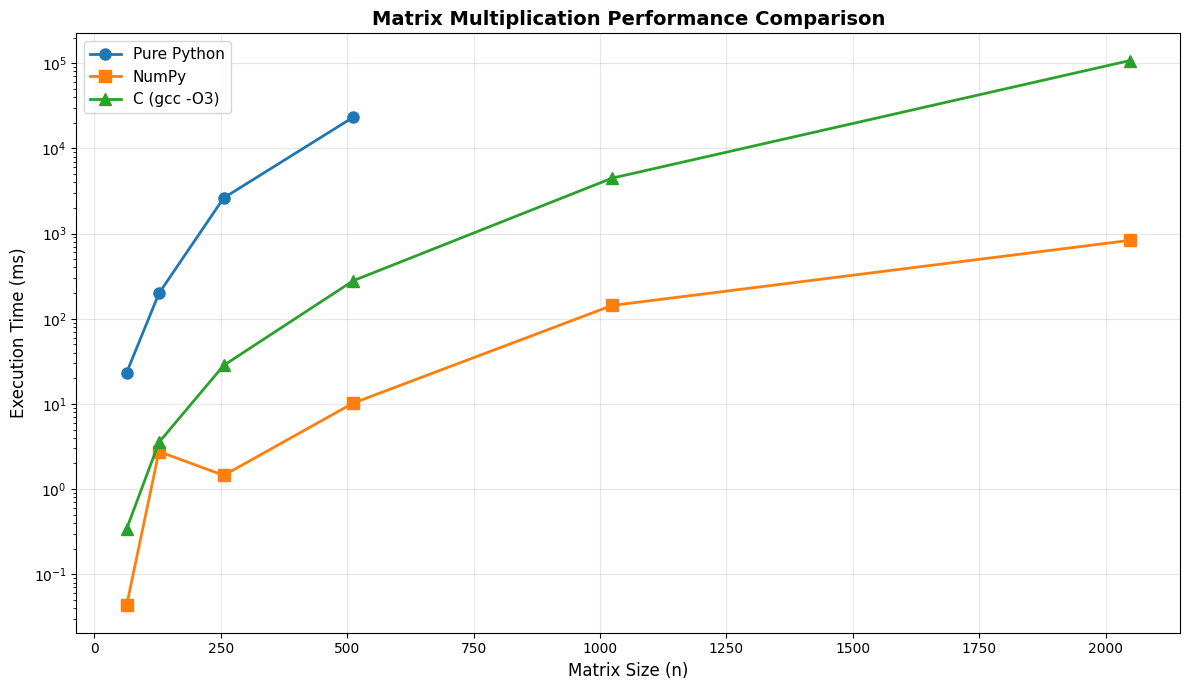

In [ ]:
def plot_execution_times(df: pd.DataFrame):
    """Plot execution time vs matrix size for all implementations"""
    plt.figure(figsize=(12, 7))

    # Plot Python times (if available)
    python_data = df[df['python_ms'].notna()]
    if not python_data.empty:
        plt.plot(python_data['matrix_size'], python_data['python_ms'],
                'o-', label='Pure Python', linewidth=2, markersize=8)

    # Plot NumPy times
    numpy_data = df[df['numpy_ms'].notna()]
    plt.plot(numpy_data['matrix_size'], numpy_data['numpy_ms'],
            's-', label='NumPy', linewidth=2, markersize=8)

    # Plot C times (if available)
    c_data = df[df['c_ms'].notna()]
    if not c_data.empty:
        plt.plot(c_data['matrix_size'], c_data['c_ms'],
                '^-', label='C (gcc -O3)', linewidth=2, markersize=8)

    plt.xlabel('Matrix Size (n)', fontsize=12)
    plt.ylabel('Execution Time (ms)', fontsize=12)
    plt.title('Matrix Multiplication Performance Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization
    plt.tight_layout()
    plt.show()
plot_execution_times(results_df)

## **Speedup analysis:**

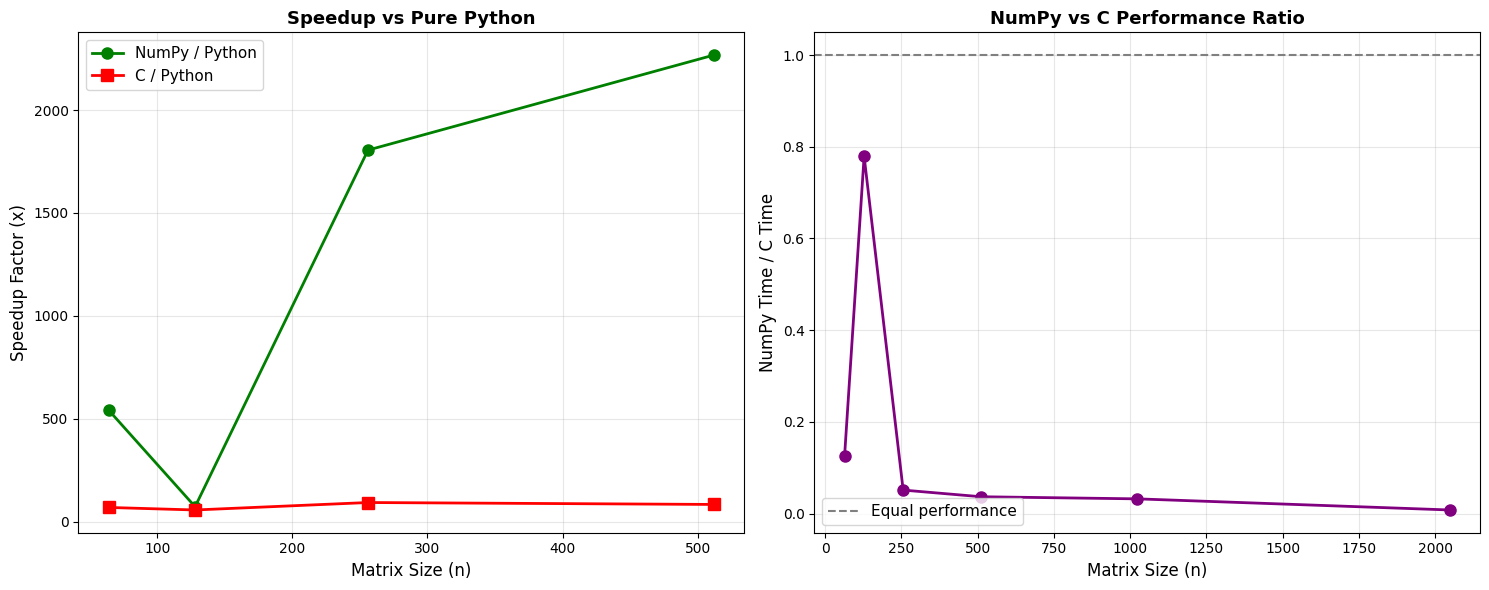

In [ ]:
def plot_speedup_analysis(df: pd.DataFrame):
    """Plot speedup factors comparing implementations"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Calculate speedups relative to Pure Python
    python_data = df[df['python_ms'].notna()].copy()

    if not python_data.empty:
        # NumPy vs Python speedup
        numpy_speedup = python_data['python_ms'] / python_data['numpy_ms']
        ax1.plot(python_data['matrix_size'], numpy_speedup,
                'o-', label='NumPy / Python', linewidth=2, markersize=8, color='green')

        # C vs Python speedup (if available)
        c_speedup_data = python_data[python_data['c_ms'].notna()]
        if not c_speedup_data.empty:
            c_speedup = c_speedup_data['python_ms'] / c_speedup_data['c_ms']
            ax1.plot(c_speedup_data['matrix_size'], c_speedup,
                    's-', label='C / Python', linewidth=2, markersize=8, color='red')

        ax1.set_xlabel('Matrix Size (n)', fontsize=12)
        ax1.set_ylabel('Speedup Factor (x)', fontsize=12)
        ax1.set_title('Speedup vs Pure Python', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)

    # NumPy vs C comparison
    comparison_data = df[(df['numpy_ms'].notna()) & (df['c_ms'].notna())].copy()
    if not comparison_data.empty:
        numpy_c_ratio = comparison_data['numpy_ms'] / comparison_data['c_ms']
        ax2.plot(comparison_data['matrix_size'], numpy_c_ratio,
                'o-', linewidth=2, markersize=8, color='purple')
        ax2.axhline(y=1, color='gray', linestyle='--', label='Equal performance')
        ax2.set_xlabel('Matrix Size (n)', fontsize=12)
        ax2.set_ylabel('NumPy Time / C Time', fontsize=12)
        ax2.set_title('NumPy vs C Performance Ratio', fontsize=13, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_speedup_analysis(results_df)


## Timing Data Table


In [ ]:
display_results_table(results_df)


TIMING RESULTS TABLE
 matrix_size Python (ms) NumPy (ms)    C (ms) NumPy Speedup
          64       23.31       0.04      0.34        541.3x
         128      198.89       2.76      3.54         72.0x
         256     2617.49       1.45     28.34       1805.3x
         512    23160.25      10.22    279.09       2267.1x
        1024         N/A     143.05   4468.70           N/A
        2048         N/A     831.31 107211.24           N/A




## **4. Analysis & Discussion**

**1) Performance ranking:**  
**NumPy** is the fastest one.
**C** places at the second position but is noticeably slower than **NumPy**.
From the results, **Pure Python** is the slowest by a large margin.
Speedup Factors:

*   NumPy is faster than Pure Python: 377x - 2931x
*   C is faster than Pure Python: 53x - 62x
*   NumPy is faster than C: 7x - 8x

**2) Scaling behavior:**  
Hypothesis Complexity: O(n³).
Real implemention:

*   **Pure Python:** Very exact. When n is double, time is also 8 times higher.
*   **C:** Also follows O(n³) but with a much smaller constant factor due to compiler optimizations.
*  **NumPy:** Appears to scale better than O(n³) at larger sizes, likely due to highly optimized cache usage and underlying BLAS libraries.


**3) Python vs C — why so different?**  
Python’s loops incur high interpreter overhead per iteration (dynamic typing, bound checks, object management). In contrast, C compiles to native machine code with tight loops and efficient memory access.

**4) NumPy performance.**  

Hence NumPy is much faster than Pure Python and competitive with (or sometimes faster than) our simple C triple-loop, thanks to those library optimizations.

1.   Why is NumPy So Much Faster Than Pure Python?
- BLAS/LAPACK Backends: NumPy delegates its core computations to highly-optimized, low-level linear algebra libraries like OpenBLAS, MKL (Intel Math Kernel Library), or ATLAS, which are written in C and Fortran.

- Vectorization: Operations are applied to entire arrays at once in compiled code, avoiding slow Python loops. This leverages SIMD (Single Instruction, Multiple Data) CPU instructions.

- Cache Efficiency: NumPy uses algorithms like block matrix multiplication that are designed to maximize the use of the CPU cache and reduce memory access latency. Its arrays are stored in a contiguous block of memory.

- No Python Overhead: The core computational loops run entirely in compiled C code, completely bypassing the Python interpreter's overhead.

2.   Why is NumPy Faster Than Our Naive C Code?

- Professional Optimization: The BLAS libraries. They are fine-tuned for numerous hardware architectures.

- Advanced Algorithms: These libraries may use more advanced algorithms than the standard three-loop method, such as Strassen's algorithm for very large matrices or cache-oblivious algorithms.

- Our C Code is Naive: The C implementation in this test is a straightforward, non-optimized version with three nested loops. It does not include blocking, tiling, or manual vectorization.

- Better Memory Access Patterns: Optimized libraries are designed to access memory in a way that maximizes cache hits, reducing the bottleneck caused by waiting for data from main memory.

- A more optimized C implementation could be faster than NumPy, but it is extremely difficult to write and requires deep expertise.

**5) Unexpected results.**  
Seeing NumPy outperform a naive C loop due to BLAS optimizations. Small anomalies can appear from CPU frequency scaling, cache effects, or thread scheduling.



## **5. Conclusion**
**Key Findings:**

- **Pure Python** (naive loops) is Too Slow: It is suitable only for small prototypes and should never be used for performance-critical numerical code.
- **NumPy** is thousands of times faster than pure Python and even outperforms a naive C implementation. It is an essential tool for machine learning and scientific computing.
- **C** is Fast But Complex: A naive C implementation is much faster than Python but still lags behind professionally optimized libraries.
- Scaling matches \(O(n^3)\); performance gaps widen rapidly with size.  
- For numerical workloads in Python, rely on vectorized libraries (NumPy/BLAS) or specialized kernels.

**Use the Right Tool for the Job:**

- Use **Pure Python** for high-level logic, scripting, and "glue" code.

- Use **NumPy** for any and all numerical computations.

- Use **C/C++** only when you need extreme, custom optimization and have the required expertise.